# Familiarity Analysis
Extract relevant data from csv:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read CSV into a DataFrame
df = pd.read_csv('D:/PilotData/PostSurvey/PostSurvey.csv')

# Get the unique participant IDs in the order they appear
unique_ids = df['id'].unique()

# Create a mapping from old ID to new formatted IDs ("01", "02", ..., "10")
new_id_map = {old_id: f'{i+1:02d}' for i, old_id in enumerate(unique_ids)}

# Apply this mapping to reassign the UID in a new column (or overwrite existing)
df['UID'] = df['id'].map(new_id_map)

# Select columns starting with 'C'
c_columns = [col for col in df.columns if col.startswith('C')]

# Exclude columns that end with 'time'
relevant_columns = [col for col in c_columns if not col.endswith('Time')]

# Now extract those columns + UID for your analysis
familiarity_df = df[['UID'] + relevant_columns]

# Verify
print(familiarity_df.head())

  UID C1M3FVSC1M4A C1M6AVSC1M1F C1M2AVSC1M5F C2M4AVSC2M1F C2M3FVSC2M6A  \
0  01         A001         A001         A002         A002         A001   
1  02         A002         A001         A002         A002         A001   
2  03         A001         A002         A002         A002         A001   
3  04         A001         A001         A002         A002         A002   
4  05         A001         A002         A001         A002         A001   

  C2M5FVSC2M2A C3M2AVSC3M5F C3M3FVSC3M6A C3M1FVSC3M4A  
0         A001         A002         A002         A001  
1         A001         A002         A001         A001  
2         A002         A002         A001         A001  
3         A002         A002         A001         A002  
4         A001         A002         A001         A001  


Create data frame suitable for analysis:

In [ ]:
question_cols = [col for col in familiarity_df.columns if col != 'UID']

records = []

for col in question_cols:
    model1, model2 = col.split('VS')
    for idx, row in df.iterrows():
        participant = row['UID']
        choice = row[col]
        if choice == 'A001':
            # model1 chosen -> familiar_count +1
            records.append({'UID': participant, 'Model': model1, 'familiar_count': 1, 'abstract_count': 0})
            # model2 not chosen -> abstract_count +1
            records.append({'UID': participant, 'Model': model2, 'familiar_count': 0, 'abstract_count': 1})
        elif choice == 'A002':
            # model2 chosen -> familiar_count +1
            records.append({'UID': participant, 'Model': model2, 'familiar_count': 1, 'abstract_count': 0})
            # model1 not chosen -> abstract_count +1
            records.append({'UID': participant, 'Model': model1, 'familiar_count': 0, 'abstract_count': 1})
        else:
            # Missing or invalid response, skip
            continue

# Create DataFrame
tidy_df = pd.DataFrame(records)

# Aggregate counts per model
summary = tidy_df.groupby('Model')[['familiar_count', 'abstract_count']].sum().reset_index()

# Verify total count for each model = number of participants
print(summary)

    Model  familiar_count  abstract_count
0   C1M1F               5               5
1   C1M2A               2               8
2   C1M3F               9               1
3   C1M4A               1               9
4   C1M5F               8               2
5   C1M6A               5               5
6   C2M1F               8               2
7   C2M2A               3               7
8   C2M3F               9               1
9   C2M4A               2               8
10  C2M5F               7               3
11  C2M6A               1               9
12  C3M1F               8               2
13  C3M2A               0              10
14  C3M3F               9               1
15  C3M4A               2               8
16  C3M5F              10               0
17  C3M6A               1               9


Plot familiar and abstract together:

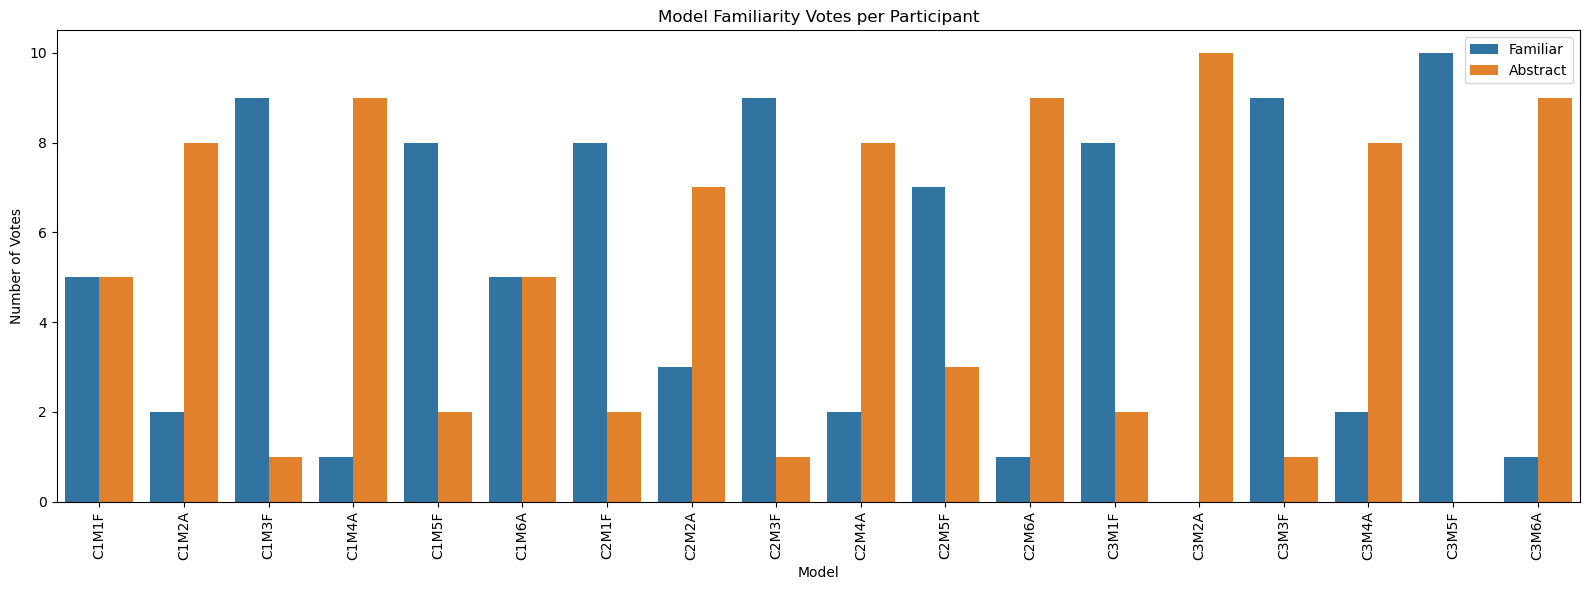

In [3]:
plot_data = summary.melt(id_vars='Model', value_vars=['familiar_count', 'abstract_count'],
                         var_name='Category', value_name='Count')

plot_data['Category'] = plot_data['Category'].map({
    'familiar_count': 'Familiar',
    'abstract_count': 'Abstract'
})

plt.figure(figsize=(16, 6))
sns.barplot(data=plot_data, x='Model', y='Count', hue='Category')
plt.xticks(rotation=90)
plt.title('Model Familiarity Votes per Participant')
plt.ylabel('Number of Votes')
plt.xlabel('Model')
plt.legend(title=None)
plt.tight_layout()
plt.show()


Plot familiar and abstract separately:

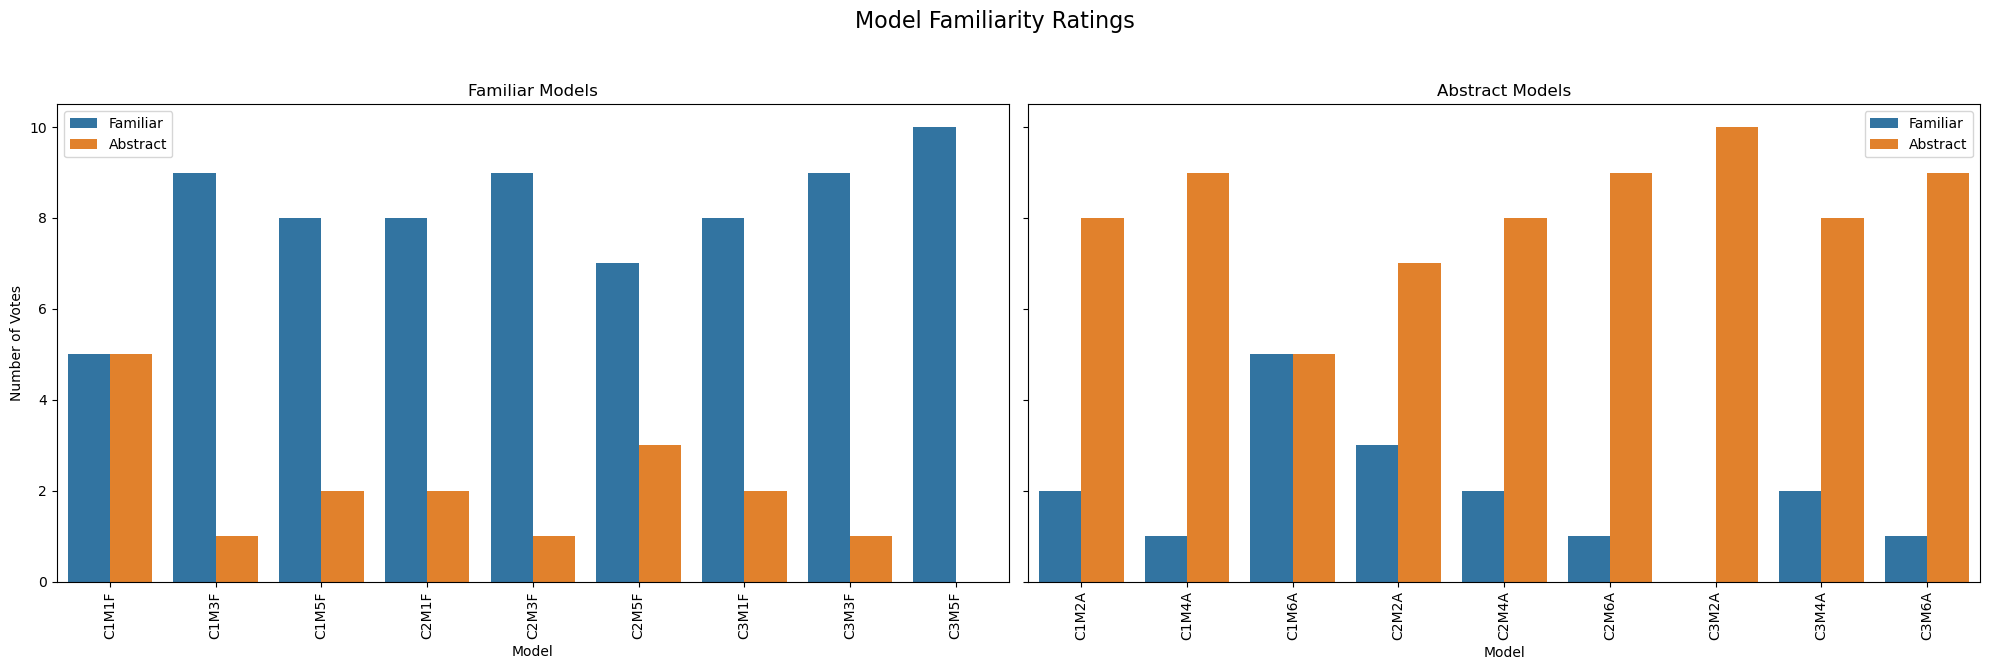

In [4]:
# Filter for familiar models (ending with F)
familiar_models = summary[summary['Model'].str.endswith('F')].copy()
# Melt for plotting
familiar_plot_data = familiar_models.melt(
    id_vars='Model',
    value_vars=['familiar_count', 'abstract_count'],
    var_name='Category',
    value_name='Count'
)
familiar_plot_data['Category'] = familiar_plot_data['Category'].map({
    'familiar_count': 'Familiar',
    'abstract_count': 'Abstract'
})

# Filter for abstract models (ending with A)
abstract_models = summary[summary['Model'].str.endswith('A')].copy()
# Melt for plotting
abstract_plot_data = abstract_models.melt(
    id_vars='Model',
    value_vars=['familiar_count', 'abstract_count'],
    var_name='Category',
    value_name='Count'
)
abstract_plot_data['Category'] = abstract_plot_data['Category'].map({
    'familiar_count': 'Familiar',
    'abstract_count': 'Abstract'
})

# Create subplots side-by-side
fig, axs = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

# Plot familiar models subplot
sns.barplot(
    data=familiar_plot_data, x='Model', y='Count', hue='Category', ax=axs[0]
)
axs[0].set_title('Familiar Models')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Number of Votes')
axs[0].tick_params(axis='x', rotation=90)
axs[0].legend(title=None)

# Plot abstract models subplot
sns.barplot(
    data=abstract_plot_data, x='Model', y='Count', hue='Category', ax=axs[1]
)
axs[1].set_title('Abstract Models')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('')
axs[1].tick_params(axis='x', rotation=90)
axs[1].legend(title=None)

plt.suptitle('Model Familiarity Ratings', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()